In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import os
import torchvision.models as models

In [4]:
def generate_grating(size, orientation, spatial_frequency):

    x = np.linspace(0, size, size)
    y = np.linspace(0, size, size)
    X, Y = np.meshgrid(x, y)

    theta = np.deg2rad(orientation)
    freq = spatial_frequency * 2 * np.pi

    grating = np.sin(freq * (X * np.cos(theta) + Y * np.sin(theta))) * 255 # convert to grayscale 

    return grating

In [179]:
#### Simulate drifting gratings ####
# full-field drifting gratings consisted of a drifting sinusoidal grating
# at a single temporal frequency (1Hz) and contrast (80%). 
# presented at 12 different directions (separated by 30 degrees) and at 2
# different spatial frequencies (0.04 and 0.08 cycles per degree)

# for our purposes, we will simulate fixed drifting gratings 
# they will have 6 different orientations (0, 30, 60, 90, 120, 150 degrees)
# and 2 different spatial frequencies (0.04 and 0.08 cycles per degree)

orientations = [0, 30, 60, 90, 120, 150]
spatial_frequencies = [0.04, 0.08]
size = 224 # pixels
repeats = 40
gratings = np.zeros((repeats * len(orientations) * len(spatial_frequencies), size, size))
label_map = {
    0: [0, 1, 2, 3, 4, 5],
    1: [6, 7, 8, 9, 10, 11]
}
grating_labels = np.zeros((repeats * len(orientations) * len(spatial_frequencies)))

for i, orientation in enumerate(orientations):
    for j, spatial_frequency in enumerate(spatial_frequencies):
        for k in range(repeats):
            gratings[(k * len(orientations) * len(spatial_frequencies)) + (i * len(spatial_frequencies)) + j] = generate_grating(size, orientation, spatial_frequency)
            grating_labels[(k * len(orientations) * len(spatial_frequencies)) + (i * len(spatial_frequencies)) + j] = label_map[j][i]

# Shuffle the gratings
# np.random.shuffle(gratings)
print(f'shape of gratings array: {gratings.shape} (should be (N, 224, 224))')
print(f'shape of grating_labels array: {grating_labels.shape} (should be (N,))')

shape of gratings array: (480, 224, 224) (should be (N, 224, 224))
shape of grating_labels array: (480,) (should be (N,))


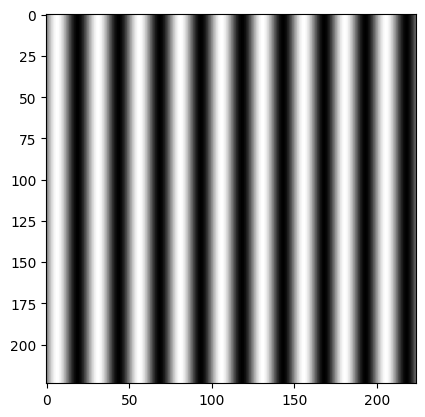

In [181]:
plt.imshow(gratings[0, :, :], cmap='gray')

In [182]:
## Load in the natural scenes images
# consisted of 118 natural images
# images 1-58 were from the Berkeley Segmentation Dataset (Martin et al., 2001)
# images 59-101 were from the van Hateren Natural Image Dataset (van Hateren and van der Schaaf, 1998)
# images 102-118 were from teh McGill Calibrated Colour Image Database (Olmos and Kingdom, 2004)

# images were presented in grayscale and were contrast normalized and resized to 1174 x 918 pixels
# images were luminance-matched (bug prevented proper matching; within 6%)

# presented for 0.25 seconds each, no inter-image gray period
# each presented ~50 times, in random order, and there were blank sweeps (i.e. mean luminence gray)
# roughly once every 100 images

from matplotlib.image import imread

repeats = 4
images = np.zeros((118 * repeats, 224, 224))
image_labels = np.zeros((118 * repeats,))
start_num = 12

# load in the images from the Berkeley Segmentation Dataset
file_list = os.listdir('/home/naomi/Downloads/BSDS300/images/train/')
for r in range(repeats):
    for i in range(118):
        image = imread(f'/home/naomi/Downloads/BSDS300/images/train/{file_list[i]}')
        image = np.dot(image, [0.2989, 0.5870, 0.1140]) # convert to grayscale
        images[(r * 118) + i] = image[int(image.shape[0]/2)-112:int(image.shape[0]/2)+112, int(image.shape[1]/2)-112:int(image.shape[1]/2)+112]
        image_labels[(r * 118) + i] = (i+start_num)

images = images.astype(int)
images.shape

(472, 224, 224)

In [191]:
# all_inputs = np.concatenate((gratings, images), axis=0)
all_inputs = images
all_inputs = all_inputs.reshape((-1, 1, 224, 224))
all_inputs = np.repeat(all_inputs, 3, axis=1) # convert to 3 channels
all_inputs.shape # (N, 3, 224, 224)

(472, 3, 224, 224)

In [192]:
# grating_id = 0
# natural_scenes_id = 1

# grating_labels = np.zeros(np.shape(gratings)[0])
# natural_scenes_labels = np.ones(np.shape(images)[0])

# all_labels = np.concatenate((grating_labels, natural_scenes_labels), axis=0)
# all_labels.shape

# all_labels = np.concatenate((grating_labels, image_labels), axis=0)
all_labels = image_labels
all_labels.shape

(472,)

In [193]:
### shuffling!!
indices = len(all_labels)
shuffled_indices = np.random.permutation(indices)

all_inputs = all_inputs[shuffled_indices]
all_labels = all_labels[shuffled_indices]

In [194]:
## Loading in the model -- ResNet18
# accepts inputs of shape [batch, 3, 224, 224]
from torchvision.models.feature_extraction import create_feature_extractor

resnet18 = models.resnet18(
    weights=models.ResNet18_Weights.IMAGENET1K_V1
).eval()

return_nodes = {
    'relu': 'stem',         # after initial conv1/bn1/relu
    'layer1': 'layer1',     # after layer1
    'layer2': 'layer2',     # after layer2
}

feature_extractor = create_feature_extractor(resnet18, return_nodes)

In [195]:
batch_size = 64
input = all_inputs[:batch_size, :, :, :]
input = torch.from_numpy(input)
input = input.float()
input.shape, input.type(), input.dtype

(torch.Size([64, 3, 224, 224]), 'torch.FloatTensor', torch.float32)

In [231]:
for p in resnet18.parameters(): p.requires_grad = False
with torch.no_grad(): 
    features = resnet18(input)

# split into train / test set and fit a linear regression 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
clf = LogisticRegression(max_iter=10000)
x_train, x_test, y_train, y_test = train_test_split(features, all_labels[:batch_size], test_size=0.2)

clf.fit(x_train, y_train)
acc = clf.score(x_test, y_test)

print(acc)

KeyboardInterrupt: 

In [ ]:
del all_features
for num_batch in range(7):
    input = all_inputs[num_batch * batch_size:(num_batch * batch_size) + batch_size]
    input = torch.from_numpy(input)
    input = input.float()
    features = resnet18(input)
    all_features = np.concatenate((all_features, features), axis=0) if 'all_features' in locals() else features

all_features.shape

In [ ]:
# split into train / test set and fit a linear regression 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
clf = LogisticRegression(max_iter=1000)
x_train, x_test, y_train, y_test = train_test_split(features, all_labels[:batch_size], test_size=0.2)

clf.fit(x_train, y_train)
acc = clf.score(x_test, y_test)

print(acc)

In [208]:
# fit regression for each layer
for i in range(10):
    for k, v in features.items():
        clf = LogisticRegression(max_iter=10000)
        v_gap = v.mean(dim=(2, 3))
        x_train, x_test, y_train, y_test = train_test_split(v_gap, all_labels[:batch_size], test_size=0.2)
        clf.fit(x_train, y_train)
        acc = clf.score(x_test, y_test)
        print(f"Accuracy for {k}: {acc}")

Accuracy for stem: 0.3076923076923077
Accuracy for layer1: 0.38461538461538464
Accuracy for layer2: 0.38461538461538464
Accuracy for stem: 0.3076923076923077
Accuracy for layer1: 0.3076923076923077
Accuracy for layer2: 0.46153846153846156
Accuracy for stem: 0.38461538461538464
Accuracy for layer1: 0.23076923076923078
Accuracy for layer2: 0.15384615384615385
Accuracy for stem: 0.3076923076923077
Accuracy for layer1: 0.3076923076923077


KeyboardInterrupt: 